# 环境准备
## 导入相关库

In [52]:
import numpy as np
from numpy.linalg import solve
import warnings
from numpy import mat
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import train_test_split
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
tf.test.gpu_device_name()

'/device:GPU:0'

## 导入谷歌云端硬盘

In [53]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 数据准备
## 读入数据

In [54]:
path = '/content/drive/MyDrive/2021/pattern_recognition/genderdata/'
#path = '/content/drive/MyDrive/genderdata/'
pathBoy = ['boy.txt','boy82.txt','boy83.txt','boynew.txt','male2017.txt','boy2018.txt','boy2019.txt']
pathGirl = ['girl.txt','girl35.txt','girl42.txt','girlnew.txt','female2017.txt','girl2018.txt','girl2019.txt']

# 读取txt文件
dataTemp = []
for i in pathBoy:
  fr = open(path+i)
  # 按行处理数据
  for line in fr.readlines():
    # 调整格式并全部转换为浮点数
    cur = line.strip().split()
    flt = [float(cur[0]),float(cur[1]),float(cur[2]),0]
    dataTemp.append(flt)
for i in pathGirl:
  fr = open(path+i)
  # 按行处理数据
  for line in fr.readlines():
    # 调整格式并全部转换为浮点数
    cur = line.strip().split()
    flt = [float(cur[0]),float(cur[1]),float(cur[2]),1]
    dataTemp.append(flt)

# 转换为矩阵
dataMat = np.mat(dataTemp)
# 每列依次为：身高、体重、鞋码、性别(0-男，1-女)
print(dataMat[:5,:])

[[173.  50.  38.   0.]
 [163.  51.  38.   0.]
 [165.  56.  38.   0.]
 [168.  56.  38.   0.]
 [171.  68.  38.   0.]]


## 标准化

In [55]:
#提取特征矩阵
data_new = dataMat[...,0:3]
#输出原数据
print('before normalize')
print(dataMat[:5,:])
#特征矩阵标准化
data_new-=np.mean(data_new,axis=0)
data_new/=np.std(data_new,axis=0)
#输出标准化后数据
print('after normalize')
print(dataMat[:5,:])


before normalize
[[173.  50.  38.   0.]
 [163.  51.  38.   0.]
 [165.  56.  38.   0.]
 [168.  56.  38.   0.]
 [171.  68.  38.   0.]]
after normalize
[[ 0.31239281 -1.02219185 -0.94269598  0.        ]
 [-1.01259215 -0.92342041 -0.94269598  0.        ]
 [-0.74759516 -0.42956318 -0.94269598  0.        ]
 [-0.35009967 -0.42956318 -0.94269598  0.        ]
 [ 0.04739582  0.75569415 -0.94269598  0.        ]]


### 划分训练集与测试集

In [56]:
# 数据划分为训练集和测试集
train1, test1 = train_test_split(dataMat,test_size=0.3, random_state=40)

## PCA主成分分析
### 计算过程

FeatValue:
 [2.33697336 0.16759128 0.31126051]
FeatVec:
 [[-0.57884912 -0.71066166  0.3998671 ]
 [-0.5506418  -0.0210245  -0.83447683]
 [-0.6014377   0.70321972  0.37915   ]]
FeatValue:
 [2.50570713 0.21905858 0.36106134]
FeatVec:
 [[-0.59262465 -0.73431972  0.33101446]
 [-0.56091437  0.08129698 -0.82387249]
 [-0.57807534  0.67391791  0.46006907]]


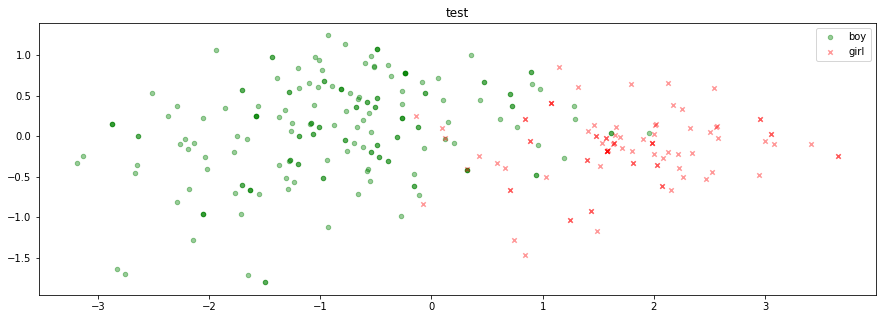

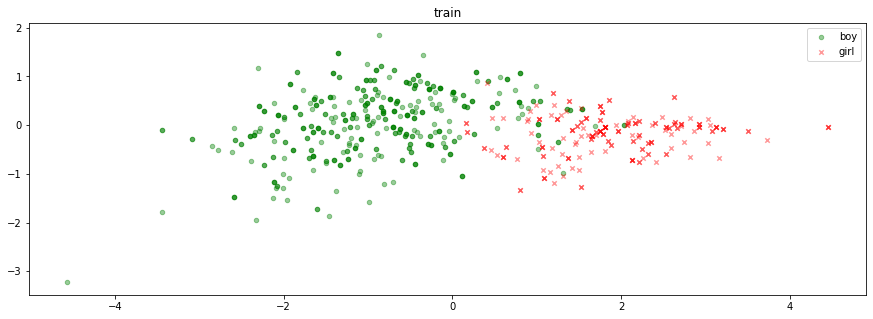

In [57]:
def pca(XMat, k):
    #取各列均值
    average = np.mean(XMat,axis=0)
    m, n = np.shape(XMat)
    data_adjust = []
    avgs = np.tile(average, (m, 1))
    #减去均值
    data_adjust = XMat - avgs
    #计算协方差矩阵
    covX = np.cov(data_adjust.T)
    #求解协方差矩阵的特征值和特征向量
    featValue, featVec=  np.linalg.eig(covX)
    #按照特征值大小进行从大到小排序
    index = np.argsort(-featValue)
    print('FeatValue:\n',featValue)
    print('FeatVec:\n',featVec)
    finalData = []
    if k > n:
        print ("k must lower than feature number")
        return
    else:
        #注意特征向量时列向量，而numpy的二维矩阵(数组)a[m][n]中，a[1]表示第1行值
        selectVec = np.matrix(featVec.T[index[:k]]) #所以这里需要进行转置
        finalData = data_adjust * selectVec.T
        reconData = (finalData * selectVec) + average
    return finalData, reconData,featValue,index

def plotBestFit(data1,original,n):
    dataArr1 = np.array(data1)
    m = np.shape(dataArr1)[0]
    male_x1 = []
    male_y1 = []
    female_x1 = []
    female_y1 = []
    #绘制降维后的散点图
    for i in range(m):
      if original[i,3] == 0:
        male_x1.append(dataArr1[i,0])
        male_y1.append(dataArr1[i,1])
      elif original[i,3] == 1:
        female_x1.append(dataArr1[i,0])
        female_y1.append(dataArr1[i,1])
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    if n == 1:
      ax.set_title('test')
    elif n == 2:
      ax.set_title('train')
    ax.scatter(male_x1, male_y1, s=20, alpha=0.4, c='green',label='boy', marker='o')
    ax.scatter(female_x1, female_y1, s=20, alpha=0.4, c='red',label='girl', marker='x')
    plt.legend()
    plt.show()
test2 = test1[...,0:3]
train2 = train1[...,0:3]
finalData_test, reconMat_test,feat_test,index_test=pca(test2,2)
finalData_train, reconMat_train,feat_train,index_train=pca(train2,2)
plotBestFit(finalData_test,test1,1)
plotBestFit(finalData_train,train1,2)

## KL图

[2.50570713 0.21905858 0.36106134]


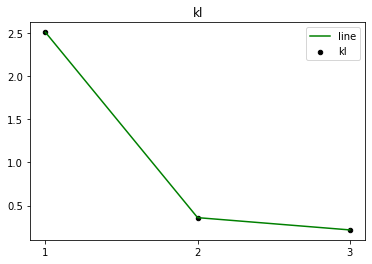

In [58]:
from matplotlib.pyplot import MultipleLocator
print(feat_train)
fea=[]
x=[1,2,3]
for i in index_train:
  fea.append(feat_train[i])
plt.rc_context({'figure.facecolor':'white'})


x_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.title('kl')
plt.scatter(x, fea, s=20, marker='o', c='k', label='kl')
plt.plot(x, fea, color='g', linestyle='-',label='line')
plt.legend()
plt.show()

## 读入数据进行分类

In [59]:
m = np.shape(test1)[0]
n = np.shape(train1)[0]
finalData_test1=np.array(finalData_test)
finalData_train1=np.array(finalData_train)

column_test = np.array(test1)[:,3]
test = np.column_stack((finalData_test1,column_test))
column_train = np.array(train1)[:,3]
train = np.column_stack((finalData_train1,column_train))

print(test[:5])
print(train[:5])

# 初始数据
male = np.asarray([[0.0,0.0,0.0],[0.0,0.0,0.0]])
female = np.asarray([[0.0,0.0,0.0],[0.0,0.0,0.0]])
male_test = np.asarray([[0,0,0],[0,0,0]])
female_test = np.asarray([[0,0,0],[0,0,0]])

# 将训练集划分成两类
for i in range(0,train.shape[0]):
  if mat(train[i, 2]) == 0:
    male=np.append(male,mat(train[i,...]),axis = 0)
  elif mat(train[i, 2]) == 1:
    female=np.append(female,mat(train[i,...]),axis = 0)

for i in range(0,2):
  male = np.delete(male,0,axis = 0)
  female = np.delete(female,0,axis = 0)

[[ 0.83781594  0.21251786  1.        ]
 [-1.06229077  0.02837805  0.        ]
 [-0.54637724  0.05326944  0.        ]
 [-0.38925291 -0.30235912  0.        ]
 [-2.64076408 -0.00376323  0.        ]]
[[-0.55606005 -0.18165077  0.        ]
 [ 0.60233075 -0.65263335  1.        ]
 [ 2.53267183 -0.04603207  1.        ]
 [-1.05473368  0.71212775  0.        ]
 [-0.45663004 -0.09804818  0.        ]]


## 用Fisher线性判别方法求分类器
### 计算过程
计算均值及离散矩阵

In [60]:
w1 = male[...,0:2].T
w2 = female[...,0:2].T
# 求均值
u1 = np.mean(w1,1)
u2 = np.mean(w2,1)
# 计算总的类内离散度矩阵Sw=s1+s2
s10 = [0,0]
s20 = [0,0]
s1 = [[0 for i in range(2)]for j in range(2)]
s2 = [[0 for i in range(2)]for j in range(2)]
for i in range(np.shape(w1)[0]):
  # 这里要注意矩阵的转置
  s1 = s1 + (np.dot(np.subtract(w1[..., i], u1) , np.subtract(w1[..., i], u1).T))
for i in range(np.shape(w2)[0]):
  s2 = s2 + (np.dot(np.subtract(w2[..., i], u2) , np.subtract(w2[..., i], u2).T))
sw = s1 + s2
# 输出离散矩阵
print(sw)
# 计算投影方向和阈值
w_x = np.dot(np.linalg.inv(sw),np.subtract(u1,u2))
# 投影后均值
u1_new = np.dot(w_x.T,u1) # 这里的顺序很重要，因为前面设置的时候没有注意，所以写的时候要注意一下
u2_new = np.dot(w_x.T,u2)
# 利用先验概率，采取阈值点w0
pw1 = np.shape(w1)[0]/(np.shape(w1)[0]+np.shape(w2)[0])
pw2 = np.shape(w2)[0]/(np.shape(w1)[0]+np.shape(w2)[0])
w0 = (u1_new+u2_new)/2 
# -math.log(pw1/pw2)/(np.shape(w1)[0]+np.shape(w2)[0]-2)
print(u1_new, u2_new, w0)

[[2.1955302  0.48594816]
 [0.48594816 0.69756743]]
[[1.50835266]] [[-3.27284067]] [[-0.88224401]]


### 训练集上结果

In [61]:
# 存储判别结果
result0 = np.zeros((len(train),2))
result1 = np.asarray([[0,0,0],[0,0,0]])
result2 = np.asarray([[0,0,0],[0,0,0]])
wrong = np.asarray([[0,0,0],[0,0,0]])
male_right = 0
male_wrong = 0
female_right = 0
female_wrong = 0
maleNum = 0
femaleNum = 0

# 逐条判别
for i in range(train.shape[0]):
  y = np.dot(w_x.T,train[i,0:2].T)
  result0[i,0] = train[i,2]
  result0[i,1] = y-w0
  if train[i,2] == 0:
    maleNum += 1
  else:
    femaleNum += 1
  if y > w0:
    result1 = np.append(result1,mat(train[i]),axis = 0)
    if train[i,2] == 1:
      male_wrong = male_wrong + 1
      wrong = np.append(wrong, mat(train[i]), axis=0)
    else:
      male_right += 1
  else:
    result2 = np.append(result2,mat(train[i]),axis = 0)
    if train[i,2] == 0:
      female_wrong = female_wrong + 1
      wrong = np.append(wrong, mat(train[i]), axis=0)
    else:
      female_right += 1

# 结果修正
for i in range(0,2):
  result1 = np.delete(result1,0,axis = 0)
  result2 = np.delete(result2,0,axis = 0)
  wrong = np.delete(wrong, 0, axis = 0)

# 输出查看结果
print('result1')
print(result1[:5,:])
print('...\n\nresult2')
print(result2[:5,:])
print('...\n\nFisher accuracy')
print((1-(female_wrong+male_wrong)/train.shape[0])*100)
print('\nFisher F1-score')
precision = male_right/(male_right+female_wrong)
recall = male_right/(male_right+male_wrong)
print(2*precision*recall/(precision+recall))

result1
[[-0.55606005 -0.18165077  0.        ]
 [-1.05473368  0.71212775  0.        ]
 [-0.45663004 -0.09804818  0.        ]
 [-0.20494939  0.6867567   0.        ]
 [-2.07035464  0.20984445  0.        ]]
...

result2
[[ 0.60233075 -0.65263335  1.        ]
 [ 2.53267183 -0.04603207  1.        ]
 [ 2.63394296  0.06840413  1.        ]
 [ 1.84398382 -0.33024077  1.        ]
 [ 3.12782346 -0.03645427  1.        ]]
...

Fisher accuracy
94.64285714285714

Fisher F1-score
0.9599109131403119


### 测试集上结果

In [62]:
# 存储判别结果
result0 = np.zeros((len(test),2))
result1 = np.asarray([[0,0,0],[0,0,0]])
result2 = np.asarray([[0,0,0],[0,0,0]])
wrong = np.asarray([[0,0,0],[0,0,0]])
male_right = 0
male_wrong = 0
female_right = 0
female_wrong = 0
maleNum = 0
femaleNum = 0

# 逐条判别
for i in range(test.shape[0]):
  y = np.dot(w_x.T,test[i,0:2].T)
  result0[i,0] = test[i,2]
  result0[i,1] = y-w0
  if test[i,2] == 0:
    maleNum += 1
  else:
    femaleNum += 1
  if y > w0:
    result1 = np.append(result1,mat(test[i]),axis = 0)
    if test[i,2] == 1:
      male_wrong = male_wrong + 1
      wrong = np.append(wrong, mat(test[i]), axis=0)
    else:
      male_right += 1
  else:
    result2 = np.append(result2,mat(test[i]),axis = 0)
    if test[i,2] == 0:
      female_wrong = female_wrong + 1
      wrong = np.append(wrong, mat(test[i]), axis=0)
    else:
      female_right += 1

# 结果修正
for i in range(0,2):
  result1 = np.delete(result1,0,axis = 0)
  result2 = np.delete(result2,0,axis = 0)
  wrong = np.delete(wrong, 0, axis = 0)

# 输出查看结果
print('result1')
print(result1[:5,:])
print('...\n\nresult2')
print(result2[:5,:])
print('...\n\nFisher accuracy')
print((1-(female_wrong+male_wrong)/test.shape[0])*100)
print('\nFisher F1-score')
precision = male_right/(male_right+female_wrong)
recall = male_right/(male_right+male_wrong)
print(2*precision*recall/(precision+recall))

result1
[[-1.06229077  0.02837805  0.        ]
 [-0.54637724  0.05326944  0.        ]
 [-0.38925291 -0.30235912  0.        ]
 [-2.64076408 -0.00376323  0.        ]
 [-1.43638854  0.97835971  0.        ]]
...

result2
[[ 0.83781594  0.21251786  1.        ]
 [ 1.79256201  0.64712413  1.        ]
 [ 1.24637747 -1.02966167  1.        ]
 [ 0.88243384 -0.05829068  1.        ]
 [ 3.05686402  0.02793693  1.        ]]
...

Fisher accuracy
93.40277777777779

Fisher F1-score
0.9496021220159152


## 结果可视化
### 画出决策边界

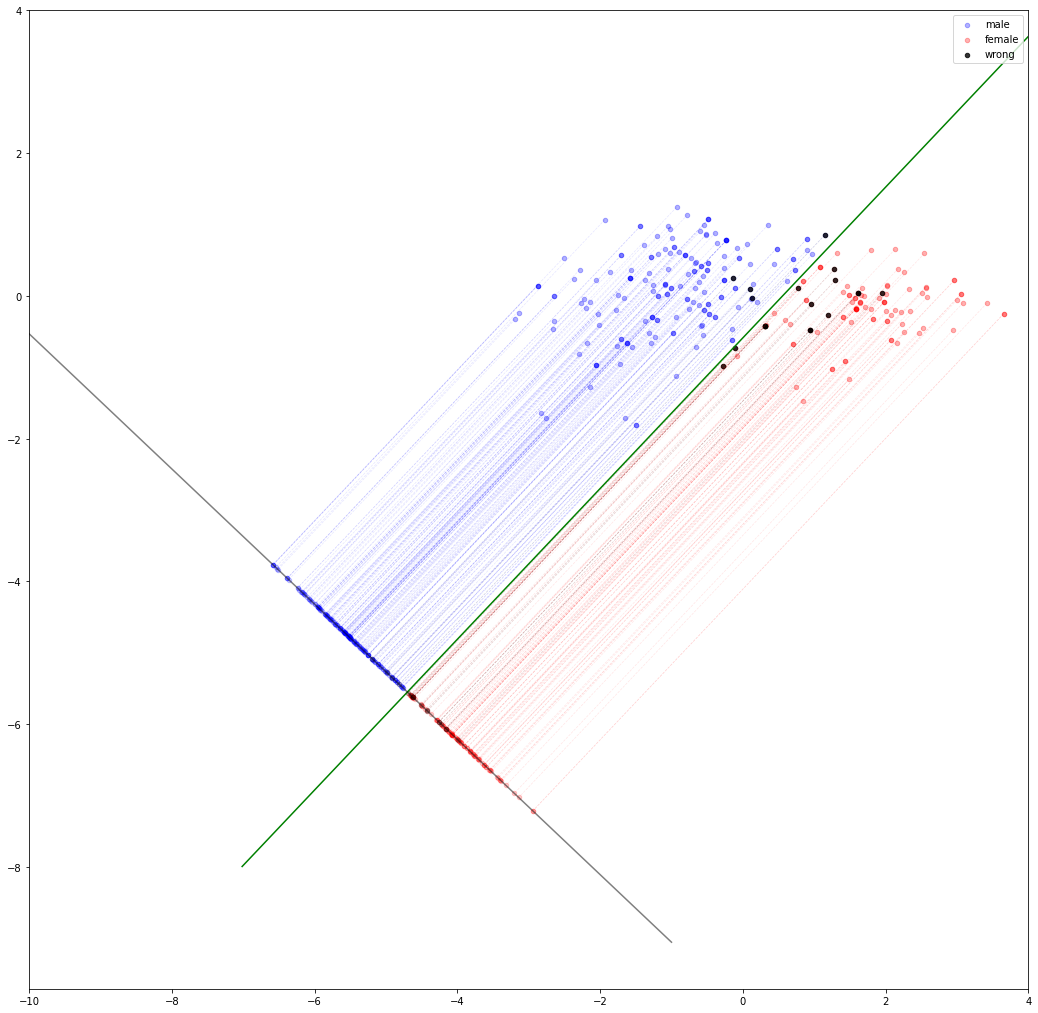

In [63]:
plt.rc_context({'figure.facecolor':'white'})

# 读入数据
for i in range(0,test.shape[0]):
  if test[i,2] == 0:
    male_test = np.append(male_test,mat(test[i,...]),axis = 0)
  elif test[i,2] == 1:
    female_test = np.append(female_test,mat(test[i,...]),axis = 0)
for i in range(0,2):
  male_test = np.delete(male_test,0,axis = 0)
  female_test = np.delete(female_test,0,axis = 0)

# 绘制散点
plt.figure(figsize=(18, 18))
plt.scatter(result1[...,0].tolist(), result1[...,1].tolist(), s=20, alpha=0.3, marker='o', c='blue', label='male')
plt.scatter(result2[...,0].tolist(), result2[...,1].tolist(), s=20, alpha=0.3, marker='o', c='red', label='female')
plt.scatter(wrong[...,0].tolist(), wrong[...,1].tolist(), s=20, alpha=0.8, marker='o', color='black', label='wrong')

# 绘制投影方向
line_x = np.arange(-10, 0, step=1)
line_y = (w_x[1,0] * line_x) / w_x[0,0] - 10
plt.plot(line_x, line_y, c='black', alpha=0.5)

# 绘制决策边界
x0 = np.linspace(-10,4,1000)
x1 = np.linspace(-8,4,1000)
x0,x1 = np.meshgrid(x0,x1)
Z = w_x.T[0,0]*x0 + w_x.T[0,1]*x1 - w0
plt.contour(x0, x1, Z, 0, colors='green')
ax=plt.gca()
ax.set_aspect(1)

# 绘制每个点的投影
# 投影线的斜率
k1 = -1/(w_x[1,0]/w_x[0,0])
# 分类别绘制投影线和投影点
for i,j in zip(result1[...,0].tolist(),result1[...,1].tolist()):
  a = np.mat([[w_x[1,0]/w_x[0,0],-1],[k1,-1]])
  b = np.mat([10,k1*i[0] - j[0]]).T
  c = solve(a,b)
  plt.plot((i[0],c[0,0]), (j[0],c[1,0]), c='blue', alpha=0.1, linestyle='--', linewidth=0.7)
  plt.scatter(c[0,0], c[1,0], s=20, alpha=0.2, marker='o', c='blue')
for i,j in zip(result2[...,0].tolist(),result2[...,1].tolist()):
  a = np.mat([[w_x[1,0]/w_x[0,0],-1],[k1,-1]])
  b = np.mat([10,k1*i[0] - j[0]]).T
  c = solve(a,b)
  plt.plot((i[0],c[0,0]), (j[0],c[1,0]), c='red', alpha=0.1, linestyle='--', linewidth=0.7)
  plt.scatter(c[0,0], c[1,0], s=20, alpha=0.2, marker='o', c='red')
for i,j in zip(wrong[...,0].tolist(),wrong[...,1].tolist()):
  a = np.mat([[w_x[1,0]/w_x[0,0],-1],[k1,-1]])
  b = np.mat([10,k1*i[0] - j[0]]).T
  c = solve(a,b)
  plt.plot((i[0],c[0,0]), (j[0],c[1,0]), c='black', alpha=0.1, linestyle='--', linewidth=0.7)
  plt.scatter(c[0,0], c[1,0], s=20, alpha=0.2, marker='o', color='black')

# 输出图像
plt.legend()
plt.show()

## ROC曲线

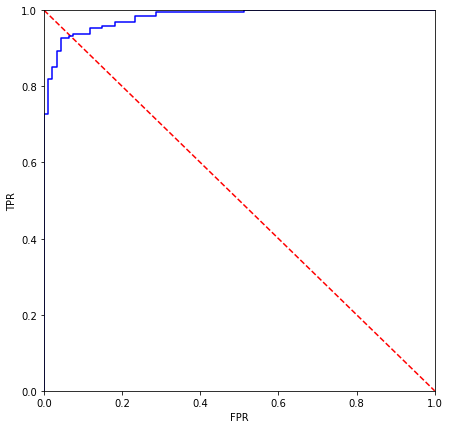

AUC:
98.11362140820356


In [64]:
result0 = result0[np.argsort(result0[:,1])][::-1]

mb = 1/maleNum
mg = 1/femaleNum
X = [0]
Y = [0]
x = 0
y = 0
count = 0

# 计算ROC曲线的坐标
for i in result0:
  if i[0] == 0:
    y += mb
  else:
    x += mg
  X.append(x)
  Y.append(y)

# 绘制图像
plt.figure(figsize=(7,7))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, 1)
plt.ylim(0, 1)

# 绘制ROC
plt.plot([0,1], [1,0], c = 'red', linestyle="--")
plt.plot(X, Y, c = 'blue')

# 涂色
y2 = [0]*len(X)
#plt.fill_between(X, Y, y2, where = Y > y2, facecolor=(193/256, 210/256, 240/256),interpolate=True)

# 输出图像
plt.show()

# 计算并输出AUC
print('AUC:')
print(roc_auc_score(-1*result0[:,0], result0[:,1])*100)

## PCA前后比较

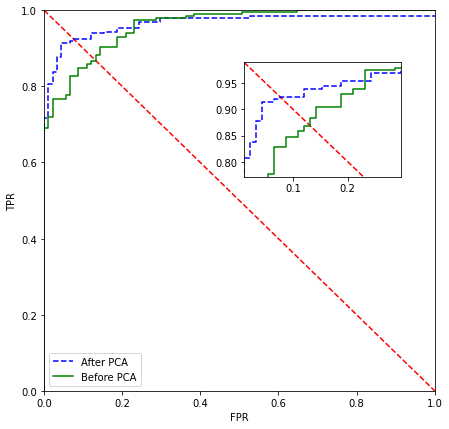

AFTER-PCA-AUC:
98.11362140820356
BEFORE-PCA-AUC:
95.9613990070843


In [65]:
# 未进行PCA降维
train1, test1 = train_test_split(dataMat,test_size=0.3, random_state=50)
# 初始数据
male1 = np.asarray([[0,0,0,0],[0,0,0,0]])
female1 = np.asarray([[0,0,0,0],[0,0,0,0]])
male_test1 = np.asarray([[0,0,0,0],[0,0,0,0]])
female_test1 = np.asarray([[0,0,0,0],[0,0,0,0]])

# 将训练集划分成两类
for i in range(0,train1.shape[0]):
  if train1[i, 3] == 0:
    male1=np.append(male1,train1[i,...],axis = 0)
  elif train1[i, 3] == 1:
    female1=np.append(female1,train1[i,...],axis = 0)
for i in range(0,2):
  male1 = np.delete(male1,0,axis = 0)
  female1 = np.delete(female1,0,axis = 0)
#print(male1[:5,:])
#print(female1[:5,:])
#print(type(train))
# 取出两类身高体重向量
w3 = male1[...,0:2].T
w4 = female1[...,0:2].T
# 求均值
u3 = np.mean(w3,1)
u4 = np.mean(w4,1)
# 计算总的类内离散度矩阵Sw=s1+s2
s11 = [0,0]
s22 = [0,0]
s3 = [[0 for i in range(2)]for j in range(2)]
s4 = [[0 for i in range(2)]for j in range(2)]
for i in range(np.shape(w3)[0]):
  # 这里要注意矩阵的转置
  s3 = s3 + (np.dot(np.subtract(w3[..., i], u3) , np.subtract(w3[..., i], u3).T))
for i in range(np.shape(w2)[0]):
  s4 = s4 + (np.dot(np.subtract(w4[..., i], u4) , np.subtract(w4[..., i], u4).T))
sw1 = s3 + s4
#print(sw1)

# 计算投影方向和阈值
w_x1 = np.dot(np.linalg.inv(sw1),np.subtract(u3,u4))
# 投影后均值
u1_new1 = np.dot(w_x1.T,u3) # 这里的顺序很重要，因为前面设置的时候没有注意，所以写的时候要注意一下
u2_new1 = np.dot(w_x1.T,u4)
# 利用先验概率，采取阈值点w0
pw1 = np.shape(w3)[0]/(np.shape(w3)[0]+np.shape(w4)[0])
pw2 = np.shape(w4)[0]/(np.shape(w3)[0]+np.shape(w4)[0])
w01 = (u1_new1+u2_new1)/2 
# -math.log(pw1/pw2)/(np.shape(w1)[0]+np.shape(w2)[0]-2)
#print(u1_new1, u2_new1, w01)

# 存储判别结果
result10 = np.zeros((len(test1),2))
result11 = np.asarray([[0,0,0,0],[0,0,0,0]])
result12 = np.asarray([[0,0,0,0],[0,0,0,0]])
wrong = np.asarray([[0,0,0,0],[0,0,0,0]])
male_right = 0
male_wrong = 0
female_right = 0
female_wrong = 0
maleNum = 0
femaleNum = 0

# 逐条判别
for i in range(test1.shape[0]):
  y = np.dot(w_x1.T,test1[i,0:2].T)
  result10[i,0] = test1[i,3]
  result10[i,1] = y-w01
  if test1[i,3] == 0:
    maleNum += 1
  else:
    femaleNum += 1
  if y > w01:
    result11 = np.append(result11,test1[i],axis = 0)
    if test1[i,3] == 1:
      male_wrong = male_wrong + 1
      wrong = np.append(wrong, test1[i], axis=0)
    else:
      male_right += 1
  else:
    result12 = np.append(result12,test1[i],axis = 0)
    if test1[i,3] == 0:
      female_wrong = female_wrong + 1
      wrong = np.append(wrong, test1[i], axis=0)
    else:
      female_right += 1

# 结果修正
for i in range(0,2):
  result11 = np.delete(result11,0,axis = 0)
  result12 = np.delete(result12,0,axis = 0)
  wrong = np.delete(wrong, 0, axis = 0)

# 输出查看结果
result0 = result0[np.argsort(result0[:,1])][::-1]
result10 = result10[np.argsort(result10[:,1])][::-1]

mb = 1/maleNum
mg = 1/femaleNum
X = [0]
Y = [0]
S = [0]
T = [0]
x = 0
y = 0
s = 0
t = 0
count = 0

# 计算ROC曲线的坐标
for i in result0:
  if i[0] == 0:
    y += mb
  else:
    x += mg
  X.append(x)
  Y.append(y)
count = 0
for j in result10:
  if j[0] == 0:
    t += mb
  else:
    s += mg
  S.append(s)
  T.append(t)
fig, ax = plt.subplots(1, 1,figsize=(7,7))
# 绘制图像
#ax.figsize=(7,7)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# 绘制ROC
ax.plot([0,1], [1,0], c = 'red', linestyle="--")

ax.plot(X, Y, c = 'blue',label='After PCA',linestyle="--")
ax.plot(S, T, c = 'green',label='Before PCA')

# 涂色
y2 = [0]*len(X)
#plt.fill_between(X, Y, y2, where = Y > y2, facecolor=(193/256, 210/256, 240/256),interpolate=True)
axins = inset_axes(ax, width="40%", height="30%", loc='lower left',
                   bbox_to_anchor=(0.5, 0.55, 1, 1), 
                   bbox_transform=ax.transAxes)
axins.plot([0,1], [1,0], c = 'red', linestyle="--")
axins.plot(X, Y, c = 'blue',linestyle="--")
axins.plot(S, T, c = 'green')

# 设置放大区间
zone_left = 160
zone_right = 220

# 坐标轴的扩展比例（根据实际数据调整）
x_ratio = 0    # x轴显示范围的扩展比例
y_ratio = 0.05   # y轴显示范围的扩展比例

# X轴的显示范围
x = np.hstack((X[zone_left:zone_right],S[zone_left:zone_right]))
xlim0 = np.min(x)-(np.max(x)-np.min(x))*x_ratio
xlim1 = np.max(x)+(np.max(x)-np.min(x))*x_ratio

# Y轴的显示范围
y = np.hstack((Y[zone_left:zone_right], T[zone_left:zone_right]))
ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio

# 调整子坐标系的显示范围
axins.set_xlim(xlim0, xlim1)
axins.set_ylim(ylim0, ylim1)


# 输出图像
ax.legend()
plt.show()


# 计算并输出AUC
print('AFTER-PCA-AUC:')
print(roc_auc_score(-1*result0[:,0], result0[:,1])*100)
print('BEFORE-PCA-AUC:')
print(roc_auc_score(-1*result10[:,0], result10[:,1])*100)
#print('等错误率：')

## 交叉验证

In [66]:
accuracy_all=0
precision_all=0
recall_all=0
accuracy1_all=0
precision1_all=0
recall1_all=0
#取特征
data_fea = dataMat[...,0:3]
#pca
finalData_cha, reconMat_cha,feat_cha,index_cha=pca(data_fea,2)
#粘特征&类别
column_cha = np.array(dataMat)[:,3]
pca_data = np.column_stack((finalData_cha,column_cha))
#print("pca")
#print(pca_data[:5,:])
print('\n---------------------------------------------------------\n')
#k折交叉
kf=KFold(n_splits=10,shuffle=True,random_state=40)
for train_index,test_index in kf.split(pca_data.data):
  #分裂训练和测试集
  
  train_cha=pca_data[train_index]
  test_cha=pca_data[test_index]

  #初始化
  male_cha = np.asarray([[0.0,0.0,0.0],[0.0,0.0,0.0]])
  female_cha = np.asarray([[0.0,0.0,0.0],[0.0,0.0,0.0]])
  male_test_cha = np.asarray([[0,0,0],[0,0,0]])
  female_test_cha = np.asarray([[0,0,0],[0,0,0]])
 
  # 将训练集划分成两类
  for i in range(0,train_cha.shape[0]):
    if mat(train_cha[i, 2]) == 0:
      male_cha=np.append(male,mat(train_cha[i,...]),axis = 0)
    elif mat(train_cha[i, 2]) == 1:
      female_cha=np.append(female,mat(train_cha[i,...]),axis = 0)

  for i in range(0,2):
   male_cha = np.delete(male_cha,0,axis = 0)
   female_cha = np.delete(female_cha,0,axis = 0)
  
  #fisher

  w1_cha = male_cha[...,0:2].T
  w2_cha = female_cha[...,0:2].T
  # 求均值
  u1_cha = np.mean(w1_cha,1)
  u2_cha = np.mean(w2_cha,1)
  # 计算总的类内离散度矩阵Sw=s1+s2
  s10_cha = [0,0]
  s20_cha = [0,0]
  s1_cha = [[0 for i in range(2)]for j in range(2)]
  s2_cha = [[0 for i in range(2)]for j in range(2)]
  for i in range(np.shape(w1)[0]):
    s1_cha = s1_cha + (np.dot(np.subtract(w1_cha[..., i], u1_cha) , np.subtract(w1_cha[..., i], u1_cha).T))
  for i in range(np.shape(w2)[0]):
    s2_cha = s2_cha + (np.dot(np.subtract(w2_cha[..., i], u2_cha) , np.subtract(w2_cha[..., i], u2_cha).T))
  sw_cha = s1_cha + s2_cha
  
  # 计算投影方向和阈值
  w_x_cha = np.dot(np.linalg.inv(sw_cha),np.subtract(u1_cha,u2_cha))
  # 投影后均值
  u1_new_cha = np.dot(w_x_cha.T,u1_cha) 
  u2_new_cha = np.dot(w_x_cha.T,u2_cha)
  # 利用先验概率，采取阈值点w0
  pw1_cha = np.shape(w1_cha)[0]/(np.shape(w1_cha)[0]+np.shape(w2_cha)[0])
  pw2_cha = np.shape(w2_cha)[0]/(np.shape(w1_cha)[0]+np.shape(w2_cha)[0])
  w0_cha = (u1_new_cha+u2_new_cha)/2 
 

  # 存储判别结果
  result0_cha = np.zeros((len(test_cha),2))
  result1_cha = np.asarray([[0,0,0],[0,0,0]])
  result2_cha = np.asarray([[0,0,0],[0,0,0]])
  wrong_cha = np.asarray([[0,0,0],[0,0,0]])
  male_right_cha = 0  
  male_wrong_cha = 0
  female_right_cha = 0
  female_wrong_cha = 0
  maleNum_cha = 0
  femaleNum_cha = 0

  # 逐条判别
  for i in range(test_cha.shape[0]):
    y_cha = np.dot(w_x_cha.T,test_cha[i,0:2].T)
    result0_cha[i,0] = test_cha[i,2]
    result0_cha[i,1] = y_cha-w0_cha
    if test_cha[i,2] == 0:
      maleNum_cha += 1
    else:
      femaleNum_cha += 1
    if y_cha > w0_cha:
     result1_cha = np.append(result1_cha,mat(test_cha[i]),axis = 0)
     if test_cha[i,2] == 1:
       male_wrong_cha = male_wrong_cha + 1
       wrong_cha = np.append(wrong_cha, mat(test_cha[i]), axis=0)
     else:
       male_right_cha += 1
    else:
     result2_cha = np.append(result2_cha,mat(test_cha[i]),axis = 0)
     if test_cha[i,2] == 0:
       female_wrong_cha = female_wrong_cha + 1
       wrong_cha = np.append(wrong_cha, mat(test_cha[i]), axis=0)
     else:
       female_right_cha += 1

  # 结果修正
  for i in range(0,2):
    result1_cha = np.delete(result1,0,axis = 0)
    result2_cha = np.delete(result2,0,axis = 0) 
    wrong_cha = np.delete(wrong, 0, axis = 0)  
  
  accuracy_all=accuracy_all+(1-(female_wrong_cha+male_wrong_cha)/test_cha.shape[0])*100
  
  precision_cha = male_right_cha/(male_right_cha+female_wrong_cha)
  recall_cha = male_right_cha/(male_right_cha+male_wrong_cha)
  precision_all= precision_all+precision_cha
  recall_all=recall_all+recall_cha
  #print('...\n\nFisher accuracy')
  #print((1-(female_wrong_cha+male_wrong_cha)/test_cha.shape[0])*100)
  #print('\nFisher F1-score')
  #print(2*precision_cha*recall_cha/(precision_cha+recall_cha))
  


  
  train1_cha=dataMat[train_index]
  test1_cha=dataMat[test_index]
  # 初始数据
  male1_cha = np.asarray([[0,0,0,0],[0,0,0,0]])
  female1_cha = np.asarray([[0,0,0,0],[0,0,0,0]])
  male_test1_cha = np.asarray([[0,0,0,0],[0,0,0,0]])
  female_test1_cha = np.asarray([[0,0,0,0],[0,0,0,0]])

  # 将训练集划分成两类
  for i in range(0,train1.shape[0]):
    if train1_cha[i, 3] == 0:
      male1_cha=np.append(male1_cha,train1_cha[i,...],axis = 0)
    elif train1[i, 3] == 1:
      female1_cha=np.append(female1_cha,train1_cha[i,...],axis = 0)
  for i in range(0,2):
    male1_cha = np.delete(male1_cha,0,axis = 0)
    female1_cha = np.delete(female1_cha,0,axis = 0)
 
  w3_cha = male1_cha[...,0:2].T
  w4_cha = female1_cha[...,0:2].T
  # 求均值
  u3_cha = np.mean(w3_cha,1)
  u4_cha = np.mean(w4_cha,1)
  # 计算总的类内离散度矩阵Sw=s1+s2
  s11_cha = [0,0]
  s22_cha = [0,0]
  s3_cha = [[0 for i in range(2)]for j in range(2)]
  s4_cha = [[0 for i in range(2)]for j in range(2)]
  for i in range(np.shape(w3)[0]):
    # 这里要注意矩阵的转置
    s3_cha = s3_cha + (np.dot(np.subtract(w3_cha[..., i], u3_cha) , np.subtract(w3_cha[..., i], u3_cha).T))
  for i in range(np.shape(w2)[0]):
    s4_cha = s4_cha + (np.dot(np.subtract(w4_cha[..., i], u4_cha) , np.subtract(w4_cha[..., i], u4_cha).T))
  sw1_cha = s3_cha + s4_cha
  #print(sw1)

  # 计算投影方向和阈值
  w_x1_cha = np.dot(np.linalg.inv(sw1_cha),np.subtract(u3_cha,u4_cha))
  # 投影后均值
  u1_new1_cha = np.dot(w_x1_cha.T,u3_cha) # 这里的顺序很重要，因为前面设置的时候没有注意，所以写的时候要注意一下
  u2_new1_cha = np.dot(w_x1_cha.T,u4_cha)
  # 利用先验概率，采取阈值点w0
  pw1_cha = np.shape(w3_cha)[0]/(np.shape(w3_cha)[0]+np.shape(w4_cha)[0])
  pw2_cha = np.shape(w4_cha)[0]/(np.shape(w3_cha)[0]+np.shape(w4_cha)[0])
  w01_cha = (u1_new1_cha+u2_new1_cha)/2 
 

  # 存储判别结果
  result10_cha = np.zeros((len(test1_cha),2))
  result11_cha = np.asarray([[0,0,0,0],[0,0,0,0]])
  result12_cha = np.asarray([[0,0,0,0],[0,0,0,0]])
  wrong_cha = np.asarray([[0,0,0,0],[0,0,0,0]])
  male_right_cha = 0
  male_wrong_cha = 0
  female_right_cha = 0
  female_wrong_cha = 0
  maleNum_cha = 0
  femaleNum_cha = 0

  # 逐条判别
  for i in range(test1_cha.shape[0]):
    y_cha = np.dot(w_x1_cha.T,test1_cha[i,0:2].T)
    result10_cha[i,0] = test1_cha[i,3]
    result10_cha[i,1] = y_cha-w01_cha
    if test1_cha[i,3] == 0:
     maleNum_cha += 1
    else:
     femaleNum_cha += 1
    if y_cha > w01:
     result11_cha = np.append(result11_cha,test1_cha[i],axis = 0)
     if test1_cha[i,3] == 1:
       male_wrong_cha = male_wrong_cha + 1
       wrong_cha = np.append(wrong_cha, test1_cha[i], axis=0)
     else:
       male_right_cha += 1
    else:
     result12_cha = np.append(result12_cha,test1_cha[i],axis = 0)
     if test1_cha[i,3] == 0:
       female_wrong_cha = female_wrong_cha + 1
       wrong_cha = np.append(wrong_cha, test1_cha[i], axis=0)
     else:
       female_right_cha += 1

  # 结果修正
  for i in range(0,2):
    result11_cha = np.delete(result11_cha,0,axis = 0)
    result12_cha = np.delete(result12_cha,0,axis = 0)
    wrong_cha = np.delete(wrong_cha, 0, axis = 0)

  
  precision_cha = male_right_cha/(male_right_cha+female_wrong_cha)
  recall_cha = male_right_cha/(male_right_cha+male_wrong_cha)
  #print('...\n\nFisher accuracy1')
  #print((1-(female_wrong_cha+male_wrong_cha)/test1_cha.shape[0])*100)
  #print('\nFisher F1-score1')
  #print(2*precision_cha*recall_cha/(precision_cha+recall_cha))
  accuracy1_all=accuracy1_all+(1-(female_wrong_cha+male_wrong_cha)/test_cha.shape[0])*100
  precision1_all= precision1_all+precision_cha
  recall1_all=recall1_all+recall_cha
print('result:')
print('\npca')
print("accuracy_all:",accuracy_all/10)

precision_all=precision_all/10
recall_all=recall_all/10
print("f1_score_all:",2*precision_all*recall_all/(precision_all+recall_all))
print('\nwithout pca')
print("accuracy1_all：",accuracy1_all/10)
precision1_all=precision1_all/10
recall1_all=recall1_all/10
print("f1_score1_all：",2*precision1_all*recall1_all/(precision1_all+recall1_all))




FeatValue:
 [2.45314547 0.20409857 0.34588422]
FeatVec:
 [[-0.5887341  -0.72843874  0.35038432]
 [-0.55775402  0.05233992 -0.82835438]
 [-0.58506634  0.68310873  0.43710393]]

---------------------------------------------------------

result:

pca
accuracy_all: 93.33333333333334
f1_score_all: 0.9505168338387195

without pca
accuracy1_all： 83.12499999999999
f1_score1_all： 0.8879074083358137
